# Problem Statement

The e-commerce business is quite popular today. Here, you do not need to take orders by going to each customer. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra, Paytm and Snapdeal.

Suppose you are working as a Machine Learning Engineer in an e-commerce company named 'Ebuss'. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings.

In order to do this, below is step by step approach to buid a sentiment-based product recommendation system, which includes the following tasks.


1.   Data sourcing and sentiment analysis
2.   Building a recommendation system
3.   Improving the recommendations using the sentiment analysis model
4.   Deploying the end-to-end project with a user interface




The above approach is further broken down into below steps

1. Exploratory data analysis
2. Data cleaning
3. Text preprocessing
4. Feature extraction
4. Training the text classification model
5. Creating a recommedation systems (User based and Item Based choose the bestone)
6. Evaluating the model and recommedation system using the Test data
7. Create flask application
8. Deploy the application to heroku platform

# Import Modules

In [1]:
# General purpose libraries
import os
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# NLTK libraries
import nltk
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
import unicodedata
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import html

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [4]:
# Modelling
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import pickle

# Install imblearn if not already installed
try:
    import imblearn
except ImportError:
    !pip install imblearn

try:
    import xgboost
except ImportError:
    !pip install xgboost


from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,f1_score,precision_score,accuracy_score
import xgboost as xgb
from collections import Counter
from sklearn.metrics import pairwise_distances


# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score


In [5]:
# Environment variable
try:
    import dotenv
except ImportError:
    !pip install dotenv

from dotenv import load_dotenv, find_dotenv
import logging


# Common funtions

In [6]:
def get_logger(name: str = 'application', log_file: str = 'application.log', level: int = logging.INFO) -> logging.Logger:
    logger = logging.getLogger(name)
    logger.setLevel(level)
    logger.propagate = False # Prevent messages from being passed to the root logger

    # Ensure handlers are not duplicated if called multiple times
    if not logger.handlers:
        # Create formatter
        # formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

        # Determine logging destination from environment variable
        log_destination = os.getenv('LOG_DESTINATION', 'console').lower()

        if log_destination == 'console':
            console_handler = logging.StreamHandler()
            console_handler.setLevel(level)
            console_handler.setFormatter(formatter)
            logger.addHandler(console_handler)
        elif log_destination == 'file':
            file_handler = logging.FileHandler(log_file)
            file_handler.setLevel(level)
            file_handler.setFormatter(formatter)
            logger.addHandler(file_handler)
        else: # Default to both console and file
            file_handler = logging.FileHandler(log_file)
            file_handler.setLevel(level)
            file_handler.setFormatter(formatter)
            logger.addHandler(file_handler)

            console_handler = logging.StreamHandler()
            console_handler.setLevel(logging.INFO) # Console usually INFO level
            console_handler.setFormatter(formatter)
            logger.addHandler(console_handler)

    return logger
logger = get_logger()

In [7]:
def get_missing_row_count (df : pd.DataFrame) -> pd.Series:
  return df.isnull().sum()

In [8]:
def plot_bar_graph(df: pd.DataFrame, annotate : bool = True,hue_column=None, title : str = None, xlabel : str =None, ylabel: str = None, figsize=(10, 6), x_tick_rotation : int =90, freq_rotation : int =90) -> None:

    # Set the theme of the plot to dark grid
    sns.set_theme(style="darkgrid")

    # Set the figure size
    plt.figure(figsize=figsize)

    # Calculate value counts for the data and extract x and y values for the plot
    y_data = df.value_counts()
    x_data = y_data.index

    # Create a bar plot
    sns.barplot(x=x_data, y=y_data.values, hue=None)

    # Display frequency on top of the bars with rotation
    if annotate:
        for p in plt.gca().patches:
            plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='left', va='bottom', rotation=freq_rotation)

    # Set title and labels
    if title:
        plt.title(title, fontsize=14)
    if xlabel:
        plt.xlabel(xlabel, fontsize=12)
    if ylabel:
        plt.ylabel(ylabel, fontsize=12)

    # Rotate x-axis labels
    plt.xticks(rotation=x_tick_rotation)

    # Show the plot
    plt.show()

    # Print normalized value counts (percentages) of the data
    labels = df.value_counts(normalize=True).mul(100).round(1)
    for index, value in zip(labels.index, labels.values): print(f'{index} : {value} %')

In [9]:
def plot_simple_countplot(df : pd.DataFrame, x_col: str, figsize: tuple = (6, 6)) -> None :
    # Set the figure size
    plt.figure(figsize=figsize)

    # Create a count plot for the specified column in the DataFrame
    bar_plot = sns.countplot(data=df, x=x_col)

    # Annotate bars with their respective counts
    for p in bar_plot.patches:
        bar_plot.annotate(format(p.get_height(), '.0f'),
                          (p.get_x() + p.get_width() / 2., p.get_height()),
                          ha='center', va='center', xytext=(0, 5),
                          textcoords='offset points')

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=90)

    # Show the plot
    plt.show()

    # Print normalized value counts (percentages) of the specified column
    print(df[x_col].value_counts(normalize=True).mul(100).round(1).astype(str) + ' %')

# 1. Exploratory Analysis

## Load environment variables

In [10]:
file_loaded = load_dotenv(find_dotenv())
if file_loaded:
  dataset_path = os.getenv("DATA_PATH")
  file_name = os.getenv("FILE_NAME")
else:
  dataset_path = "./Dataset/"
  file_name = "sample30.csv"

data = dataset_path + file_name
if dataset_path:
  logger.info(f"Successfully loaded {data}")
else:
  logger.error(f"Failed to load {data}")

2025-11-16 07:21:07,031 - INFO - Successfully loaded ./Dataset/sample30.csv


## Load Data and print random row

In [11]:
# # Reading the input from folder
master_df = pd.read_csv(data)
df=master_df.copy()
df.sample(1)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
15082,AVpf4oLxLJeJML43FcxC,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2009-08-24T00:00:00.000Z,NaN,True,5,The Ready Index Double Column Table of Content...,Excellent Product,NaN,NaN,patcps,Positive


## Understand the data

In [12]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [13]:
number_of_reviews = len(df['reviews_text'])
logger.info(f"Number of reviews: {number_of_reviews}")

logger.info(f"Unique reviewers are: {len(df['reviews_username'].unique())}")

logger.info(f"Average rating score:{round(df['reviews_rating'].mean(),2)}")

2025-11-16 07:21:07,363 - INFO - Number of reviews: 30000
2025-11-16 07:21:07,370 - INFO - Unique reviewers are: 24915
2025-11-16 07:21:07,371 - INFO - Average rating score:4.48


In [14]:
get_missing_row_count(df)

,0
id,0
brand,0
categories,0
manufacturer,141
name,0
reviews_date,46
reviews_didPurchase,14068
reviews_doRecommend,2570
reviews_rating,0
reviews_text,0


Required columns for reviews_rating, reviews_text and user_sentiment doesn't have null/na values

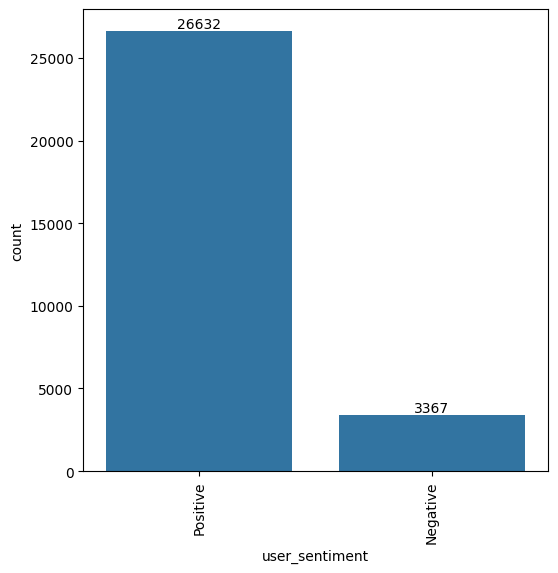

user_sentiment
Positive    88.8 %
Negative    11.2 %
Name: proportion, dtype: object


In [15]:
plot_simple_countplot(df, 'user_sentiment')

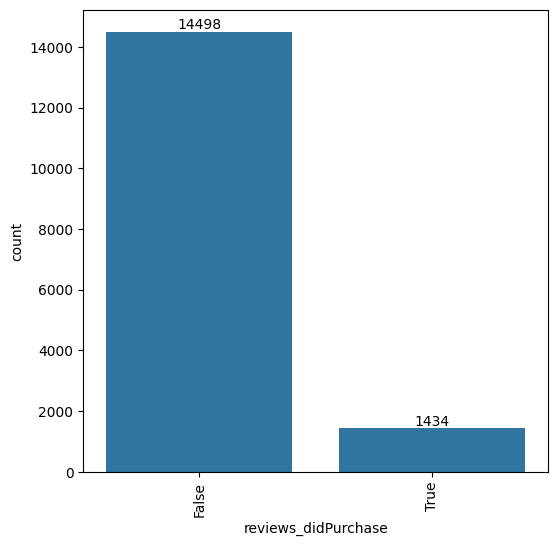

reviews_didPurchase
False    91.0 %
True      9.0 %
Name: proportion, dtype: object


In [16]:
plot_simple_countplot(df, 'reviews_didPurchase')

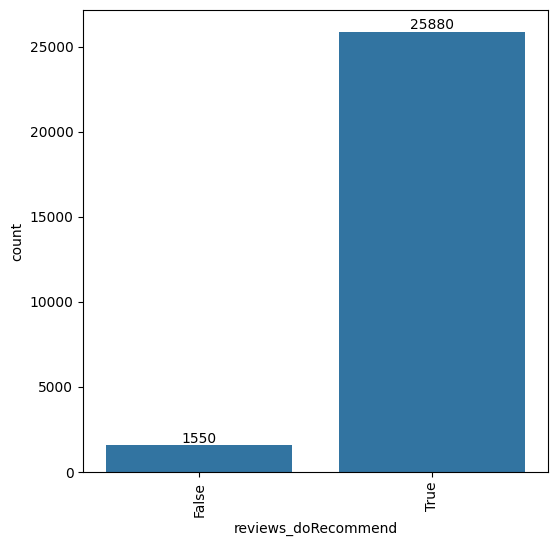

reviews_doRecommend
True     94.3 %
False     5.7 %
Name: proportion, dtype: object


In [17]:
plot_simple_countplot(df, 'reviews_doRecommend')

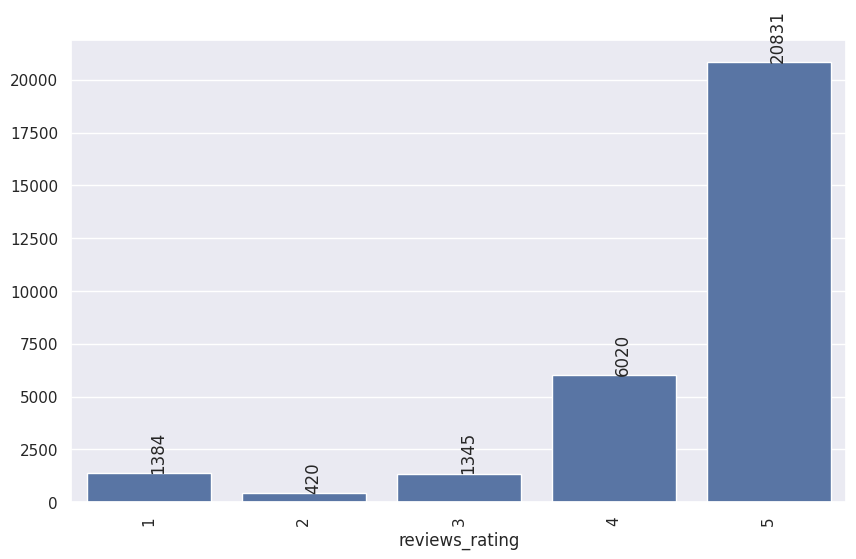

5 : 69.4 %
4 : 20.1 %
1 : 4.6 %
3 : 4.5 %
2 : 1.4 %


In [18]:
plot_bar_graph(df['reviews_rating'])

## Get top 10 brands for positive and negative sentiments

<Axes: xlabel='brand'>

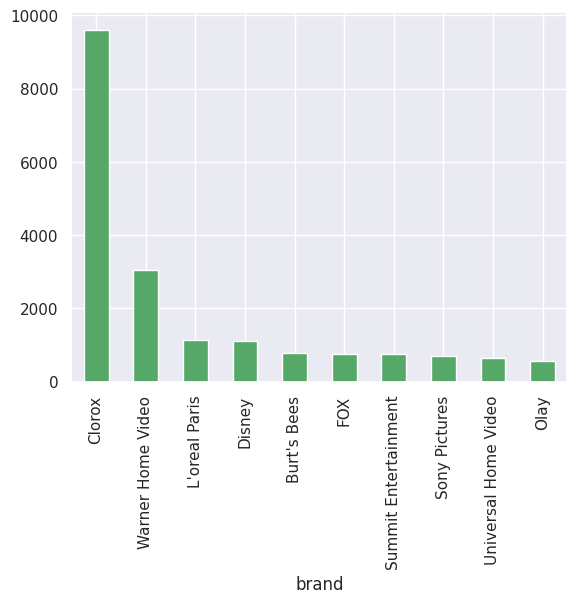

In [19]:
# Filter the top 10 brands among the positive sentiments
df[df['user_sentiment']=='Positive'].groupby('brand')['brand'].count().sort_values(ascending=False)[:10].plot(kind='bar',color='g')

<Axes: xlabel='brand'>

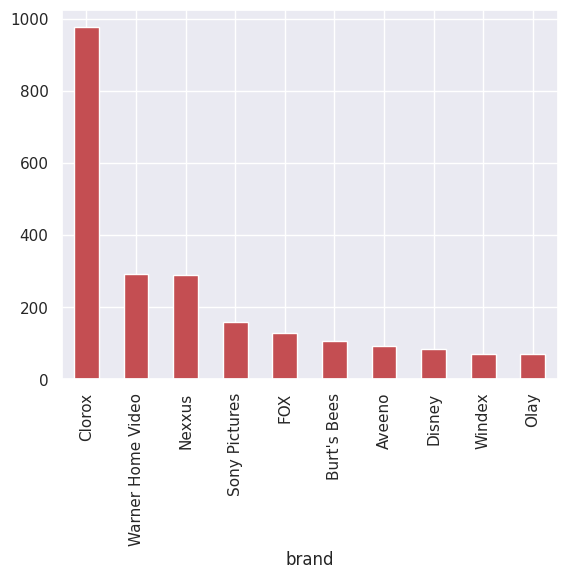

In [20]:
# Filter the top 10 brands among the positive sentiments
df[df['user_sentiment']=='Negative'].groupby('brand')['brand'].count().sort_values(ascending=False)[:10].plot(kind='bar',color='r')

#  2. Data Cleaning

In [21]:
logger.info(f'size of the data {df.shape}')

2025-11-16 07:21:08,514 - INFO - size of the data (30000, 15)


In [22]:
# Checking for duplicate data if any
df[df.duplicated()].shape

(0, 15)

In [23]:
# Finding the number of rows with Null values
missing = round(100 * df.isnull().sum()/len(df.index), 2)
missing.sort_values(ascending = False)

,0
reviews_userProvince,99.43
reviews_userCity,93.57
reviews_didPurchase,46.89
reviews_doRecommend,8.57
reviews_title,0.63
manufacturer,0.47
reviews_username,0.21
reviews_date,0.15
id,0.00
brand,0.00


In [24]:
logger.info(f'Removing reviews_userProvince and reviews_userCity columns since the records are mostly blank.')

2025-11-16 07:21:08,618 - INFO - Removing reviews_userProvince and reviews_userCity columns since the records are mostly blank.


In [25]:
df = df.drop(columns=['reviews_userCity','reviews_userProvince'],axis=1)

In [26]:
df['user_sentiment'].value_counts()

,count
user_sentiment,
Positive,26632
Negative,3367


In [27]:
# for correcting the user sentiment according to rating
def user_sentiment_from_reviews_rating(x):
  if x >= 3 :
    return 'Postive'
  elif x > 0 and x < 3  :
    return 'Negative'

In [28]:
df['user_sentiment_from_reviews_rating'] = df['reviews_rating'].apply(user_sentiment_from_reviews_rating)

In [29]:
df['user_sentiment_from_reviews_rating'].value_counts()

,count
user_sentiment_from_reviews_rating,
Postive,28196
Negative,1804


Considering review rating having 3+ score as positive, there is a Negative sentiment reviews are drastically reduced. This indicates that there are 1254 users (1640 - 384) whose review rating and sentiments is not matching

# 3. Text Preprocessing

## Text processing includes converting text to lower case, cleaning the text by removing special charaters

In [30]:
# special_characters removal
def remove_special_characters(text :str, remove_digits=True) -> str:
    """Remove the special Characters"""
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def convert_to_lowercase(words : str) -> str:
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation_and_splchars(words :str) -> str:
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_word = remove_special_characters(new_word, True)
            new_words.append(new_word)
    return new_words

stopword_list= stopwords.words('english')

def remove_stopwords(words : str) -> str:
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopword_list:
            new_words.append(word)
    return new_words

def stem_words(words : str) -> str :
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words : str) -> str:
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words : str) -> str:
    words = convert_to_lowercase(words)
    words = remove_punctuation_and_splchars(words)
    words = remove_stopwords(words)
    return words

def lemmatize(words : str) -> str:
    lemmas = lemmatize_verbs(words)
    return lemmas

In [31]:
def normalize_text(input_text : str) -> str:
    input_text = remove_special_characters(input_text)
    words = nltk.word_tokenize(input_text)
    words = normalize(words)
    lemmas = lemmatize(words)
    return ' '.join(lemmas)

### Create a separate dataframe to capture processed text

In [32]:
df_review = df[['reviews_text','user_sentiment']]

In [33]:
# create a new column lemmatized_review using the emmatize_text function
df_review['lemmatized_text'] = df_review['reviews_text'].map(lambda text: normalize_text(text))
df_review.head()

,reviews_text,user_sentiment,lemmatized_text
0,i love this album. it's very good. more to the...,Positive,love album good hip hop side current pop sound...
1,Good flavor. This review was collected as part...,Positive,good flavor review collect part promotion
2,Good flavor.,Positive,good flavor
3,I read through the reviews on here before look...,Negative,read review look buy one couple lubricants ult...
4,My husband bought this gel for us. The gel cau...,Negative,husband buy gel us gel cause irritation felt l...


In [34]:
# create separate dataframe with lemmatized text and user sentiment
df_lemmatized_user_sentiment = df_review[['lemmatized_text','user_sentiment']]

In [35]:
# Binary encoding the negative and positive to 0 and 1 respectively
df_lemmatized_user_sentiment['user_sentiment'] = df_lemmatized_user_sentiment['user_sentiment'].map({'Negative':0,'Positive':1})

## Dividing the dataset into train and test data and handle the class imbalance

In [36]:
# Jsut making sure there are no rows with NaN values in 'user_sentiment' as train_test_split with stratify cannot handle them
df_lemmatized_user_sentiment = df_lemmatized_user_sentiment.dropna(subset=['user_sentiment'])

In [37]:
# Train and Test Divide
x_train,x_test,y_train,y_test = train_test_split(df_lemmatized_user_sentiment['lemmatized_text'],
                                                 df_lemmatized_user_sentiment['user_sentiment'],
                                                 train_size=0.75,
                                                 random_state=45,
                                                 stratify=df_lemmatized_user_sentiment['user_sentiment']
                                                 )
y_train.value_counts()

,count
user_sentiment,
1.0,19974
0.0,2525


# 4. Feature Extraction using Count Vectorizer and TFIDF Transformer

In [38]:
count_vect = CountVectorizer()
x_count = count_vect.fit_transform(x_train)

tfidf_transformer = TfidfTransformer()
x_train_transformed = tfidf_transformer.fit_transform(x_count)
x_train_transformed.shape

(22499, 14794)

In [39]:
# Create the directory if it doesn't exist
pickle_dir = os.path.join(dataset_path, 'pickle_file')
os.makedirs(pickle_dir, exist_ok=True)

In [40]:
#creating the pickle for countvectorizer and TFIDF Transformer
pickle.dump(count_vect, open(os.path.join(pickle_dir, 'count_vector.pkl'), 'wb'))
pickle.dump(tfidf_transformer, open(os.path.join(pickle_dir, 'tfidf_transformer.pkl'), 'wb'))

In [41]:
count = Counter(y_train)
logger.info(f'Before sampling :{count}')

sampler = SMOTE()

x_train_sm,y_train_sm = sampler.fit_resample(x_train_transformed,y_train)

count = Counter(y_train_sm)
logger.info(f'After sampling :{count}')

2025-11-16 07:21:21,260 - INFO - Before sampling :Counter({1.0: 19974, 0.0: 2525})
2025-11-16 07:21:21,477 - INFO - After sampling :Counter({1.0: 19974, 0.0: 19974})


# 5. Training text classification model
- Logistic Regression
- Random Forest Classifer
- AdaBoost Classifier
- XGBoost
#### Choose the best model with hyperparameter tuning

In [42]:
# Function for Metrics
performance=[]

def model_metrics(y,y_pred,model_name,metrics):
  Accuracy = accuracy_score(y,y_pred)
  roc = roc_auc_score(y,y_pred)
  confusion = confusion_matrix(y,y_pred)
  precision = precision_score(y,y_pred)
  f1 = f1_score(y,y_pred)
  TP = confusion[1,1]  # true positive
  TN = confusion[0,0]  # true negatives
  FP = confusion[0,1]  # false positives
  FN = confusion[1,0]  # false negatives
  sensitivity= TP / float(TP+FN)
  specificity = TN / float(TN+FP)

  print("*"*50)
  print('Confusion Matrix =')
  print(confusion)
  print("sensitivity of the %s = %f" % (model_name,round(sensitivity,2)))
  print("specificity of the %s = %f" % (model_name,round(specificity,2)))
  print("Accuracy Score of %s = %f" % (model_name,Accuracy))
  print('ROC AUC score of %s = %f' % (model_name,roc))
  print("Report=",)
  print(classification_report(y,y_pred))
  print("*"*50)
  metrics.append(dict({'Model_name':model_name,
                       'Accuracy':Accuracy,
                       'Roc_auc_score':roc,
                       'Precision':precision,
                       'F1_score':f1}))
  return metrics



## Logistic Regression

In [43]:
%time
lr = LogisticRegression()
lr.fit(x_train_sm,y_train_sm)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


LogisticRegression()

In [44]:
y_pred = lr.predict(x_train_sm)
peformance = model_metrics(y_train_sm,y_pred,'Logistic Regression',performance)

**************************************************
Confusion Matrix =
[[19731   243]
 [ 1435 18539]]
sensitivity of the Logistic Regression = 0.930000
specificity of the Logistic Regression = 0.990000
Accuracy Score of Logistic Regression = 0.957995
ROC AUC score of Logistic Regression = 0.957995
Report=
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     19974
         1.0       0.99      0.93      0.96     19974

    accuracy                           0.96     39948
   macro avg       0.96      0.96      0.96     39948
weighted avg       0.96      0.96      0.96     39948

**************************************************


## RandomForest Classifier

In [45]:
%time
rf = RandomForestClassifier()
rf.fit(x_train_sm,y_train_sm)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


RandomForestClassifier()

In [46]:
y_pred_rf = rf.predict(x_train_sm)
performance = model_metrics(y_train_sm,y_pred_rf,'RandomForestClassifier',performance)

**************************************************
Confusion Matrix =
[[19973     1]
 [    4 19970]]
sensitivity of the RandomForestClassifier = 1.000000
specificity of the RandomForestClassifier = 1.000000
Accuracy Score of RandomForestClassifier = 0.999875
ROC AUC score of RandomForestClassifier = 0.999875
Report=
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19974
         1.0       1.00      1.00      1.00     19974

    accuracy                           1.00     39948
   macro avg       1.00      1.00      1.00     39948
weighted avg       1.00      1.00      1.00     39948

**************************************************


## AdaBoost Classifier

In [47]:
%time
xgba = GradientBoostingClassifier()
xgba.fit(x_train_sm,y_train_sm)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


GradientBoostingClassifier()

In [48]:
y_pred_xgb = xgba.predict(x_train_sm)
peformance = model_metrics(y_train_sm,y_pred_rf,'AdaBoostclassifier',peformance)

**************************************************
Confusion Matrix =
[[19973     1]
 [    4 19970]]
sensitivity of the AdaBoostclassifier = 1.000000
specificity of the AdaBoostclassifier = 1.000000
Accuracy Score of AdaBoostclassifier = 0.999875
ROC AUC score of AdaBoostclassifier = 0.999875
Report=
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19974
         1.0       1.00      1.00      1.00     19974

    accuracy                           1.00     39948
   macro avg       1.00      1.00      1.00     39948
weighted avg       1.00      1.00      1.00     39948

**************************************************


## XGBoost

In [49]:
%time
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(x_train_sm,y_train_sm)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [50]:
y_pred_xgbc = xgb_classifier.predict(x_train_sm)
peformance = model_metrics(y_train_sm,y_pred_xgbc,'XGBClassifier',peformance)

**************************************************
Confusion Matrix =
[[19683   291]
 [ 1137 18837]]
sensitivity of the XGBClassifier = 0.940000
specificity of the XGBClassifier = 0.990000
Accuracy Score of XGBClassifier = 0.964254
ROC AUC score of XGBClassifier = 0.964254
Report=
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.96     19974
         1.0       0.98      0.94      0.96     19974

    accuracy                           0.96     39948
   macro avg       0.97      0.96      0.96     39948
weighted avg       0.97      0.96      0.96     39948

**************************************************


## Review the performance across models

In [51]:
metrics_df = pd.DataFrame(performance)
metrics_df

,Model_name,Accuracy,Roc_auc_score,Precision,F1_score
0,Logistic Regression,0.957995,0.957995,0.987062,0.956703
1,RandomForestClassifier,0.999875,0.999875,0.999950,0.999875
2,AdaBoostclassifier,0.999875,0.999875,0.999950,0.999875
3,XGBClassifier,0.964254,0.964254,0.984787,0.963480


## Hyperparameter Tuning of models

### RandomForest Classifier

In [52]:
n_estimators = [600]
max_depth = [15]
min_samples_leaf = [5,6]
criterion  = ['gini','entropy']
params = {'n_estimators':n_estimators,
          'max_depth':max_depth,
          'min_samples_leaf': min_samples_leaf,
          'criterion':criterion}

In [53]:
grid_cv = GridSearchCV(estimator=rf,
                       param_grid=params,
                       n_jobs = -1,
                       scoring = 'roc_auc',
                       verbose = 1)

In [54]:
%time
grid_cv.fit(x_train_sm,y_train_sm)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs
Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [15],
                         'min_samples_leaf': [5, 6], 'n_estimators': [600]},
             scoring='roc_auc', verbose=1)

In [55]:
rf_final=grid_cv.best_estimator_
rf_final

RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=600)

In [56]:
pickle.dump(rf_final,open(os.path.join(pickle_dir, 'RandomForest_classifier.pkl'), 'wb'))

In [57]:
grid_cv.best_score_

np.float64(0.9487992603016971)

In [58]:
y_pred_rfgcv = rf_final.predict(x_train_sm)
performance = model_metrics(y_train_sm,y_pred_rfgcv,'RandomForestClassifier with hyperparmater',performance)

**************************************************
Confusion Matrix =
[[17786  2188]
 [ 1804 18170]]
sensitivity of the RandomForestClassifier with hyperparmater = 0.910000
specificity of the RandomForestClassifier with hyperparmater = 0.890000
Accuracy Score of RandomForestClassifier with hyperparmater = 0.900070
ROC AUC score of RandomForestClassifier with hyperparmater = 0.900070
Report=
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     19974
         1.0       0.89      0.91      0.90     19974

    accuracy                           0.90     39948
   macro avg       0.90      0.90      0.90     39948
weighted avg       0.90      0.90      0.90     39948

**************************************************


### AdaBoostclassifier

In [59]:
n_estimators = [600]
params_1 = {'n_estimators':n_estimators}

In [60]:
grid_cv_boost = GridSearchCV(estimator=xgba,
                       param_grid=params_1,
                       n_jobs = -1,
                       scoring = 'roc_auc',
                       verbose = 1)

In [61]:
%time
grid_cv_boost.fit(x_train_sm,y_train_sm)
print('Best score for GradientBoosting=',grid_cv_boost.best_score_)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best score for GradientBoosting= 0.9849919293861822


In [62]:
xgb_final=grid_cv_boost.best_estimator_
xgb_final

GradientBoostingClassifier(n_estimators=600)

In [63]:
y_pred_xgbgcv = xgb_final.predict(x_train_sm)
peformance = model_metrics(y_train_sm,y_pred_xgbgcv,'GradientBoostClassifier with n = 600',peformance)

**************************************************
Confusion Matrix =
[[19739   235]
 [ 1647 18327]]
sensitivity of the GradientBoostClassifier with n = 600 = 0.920000
specificity of the GradientBoostClassifier with n = 600 = 0.990000
Accuracy Score of GradientBoostClassifier with n = 600 = 0.952889
ROC AUC score of GradientBoostClassifier with n = 600 = 0.952889
Report=
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     19974
         1.0       0.99      0.92      0.95     19974

    accuracy                           0.95     39948
   macro avg       0.96      0.95      0.95     39948
weighted avg       0.96      0.95      0.95     39948

**************************************************


In [64]:
metrics_df = pd.DataFrame(performance)
metrics_df

,Model_name,Accuracy,Roc_auc_score,Precision,F1_score
0,Logistic Regression,0.957995,0.957995,0.987062,0.956703
1,RandomForestClassifier,0.999875,0.999875,0.999950,0.999875
2,AdaBoostclassifier,0.999875,0.999875,0.999950,0.999875
3,XGBClassifier,0.964254,0.964254,0.984787,0.963480
4,RandomForestClassifier with hyperparmater,0.900070,0.900070,0.892524,0.901022
5,GradientBoostClassifier with n = 600,0.952889,0.952889,0.987340,0.951163


In [65]:
#Evaluatopn between RandomForestClassifier and AdaBoostclassifier
test_performance=[]
test_word_vect = count_vect.transform(x_test)
test_tfidf_vect = tfidf_transformer.transform(test_word_vect)

y_test_pred_xgbc = rf.predict(test_tfidf_vect)
test_peformance = model_metrics(y_test,y_test_pred_xgbc,'RandomForestClassifier',test_performance)

y_test_pred_rf = xgba.predict(test_tfidf_vect)
test_peformance = model_metrics(y_test,y_test_pred_rf,'AdaBoostclassifier',test_performance)

test_metrics_df = pd.DataFrame(test_performance)
test_metrics_df

**************************************************
Confusion Matrix =
[[ 452  390]
 [ 216 6442]]
sensitivity of the RandomForestClassifier = 0.970000
specificity of the RandomForestClassifier = 0.540000
Accuracy Score of RandomForestClassifier = 0.919200
ROC AUC score of RandomForestClassifier = 0.752187
Report=
              precision    recall  f1-score   support

         0.0       0.68      0.54      0.60       842
         1.0       0.94      0.97      0.96      6658

    accuracy                           0.92      7500
   macro avg       0.81      0.75      0.78      7500
weighted avg       0.91      0.92      0.92      7500

**************************************************
**************************************************
Confusion Matrix =
[[ 748   94]
 [1239 5419]]
sensitivity of the AdaBoostclassifier = 0.810000
specificity of the AdaBoostclassifier = 0.890000
Accuracy Score of AdaBoostclassifier = 0.822267
ROC AUC score of AdaBoostclassifier = 0.851135
Report=
          

,Model_name,Accuracy,Roc_auc_score,Precision,F1_score
0,RandomForestClassifier,0.919200,0.752187,0.942916,0.955078
1,AdaBoostclassifier,0.822267,0.851135,0.982949,0.890477


### Evaluation with test data after comparing
- Considering roc_auc_score ,performance.
- RandomForestClassifier is having more score and have good accuracy

In [66]:
pickle.dump(rf,open(os.path.join(pickle_dir, 'model.pkl'), 'wb'))

# 5. Recommedation system
- User and User recommedation system
- Item and Item recommedation system

## User and User recommedation

In [67]:
logger.info(f'Unique values in the name columns are {len(df['name'].unique())}')

2025-11-16 07:59:59,163 - INFO - Unique values in the name columns are 271


In [68]:
train_df,test_df = train_test_split(df,train_size=0.70,random_state=45)
print('train shape = ',train_df.shape)
print('test shape = ',test_df.shape)

train shape =  (21000, 14)
test shape =  (9000, 14)


In [69]:
#using train_df dataset and create correlation matrix
train_pivot = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',
                             data=train_df).fillna(1)

In [70]:
train_pivot

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
zwithanx,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
zxcsdfd,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [71]:
#Creating the train_df and test_df dataset for predicting and evaluating the correlation
#fill 1 in place of Nan for prediction
train_pivot1 = pd.pivot_table(index='reviews_username', columns='name',
                            values='reviews_rating',data=train_df).fillna(1)

train_pivot1.loc['piggyboy420']

,piggyboy420
name,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0
100:Complete First Season (blu-Ray),1.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,1.0
"2x Ultra Era with Oxi Booster, 50fl oz",1.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",1.0
...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",1.0
Weleda Everon Lip Balm,1.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),1.0


In [72]:
# here we are going use the adjusted cosine similarity
def cosine_similarity(df):
    # using the adjusted cosine similarity
    mean_df = np.nanmean(df,axis=1)
    substracted_df = (df.T - mean_df).T # Normalized dataset
    # using the pairwise_distance for cosine similarity
    user_correlation = 1- pairwise_distances (substracted_df.fillna(0),metric='cosine')
    user_correlation[np.isnan(user_correlation)] = 0
    return user_correlation,substracted_df


In [73]:
user_corr_matrix,normalized_df = cosine_similarity(train_pivot1)
user_corr_matrix

array([[ 1.        , -0.00395257, -0.00395257, ..., -0.00395257,
        -0.00395257,  1.        ],
       [-0.00395257,  1.        ,  1.        , ..., -0.00395257,
        -0.00395257, -0.00395257],
       [-0.00395257,  1.        ,  1.        , ..., -0.00395257,
        -0.00395257, -0.00395257],
       ...,
       [-0.00395257, -0.00395257, -0.00395257, ...,  1.        ,
         1.        , -0.00395257],
       [-0.00395257, -0.00395257, -0.00395257, ...,  1.        ,
         1.        , -0.00395257],
       [ 1.        , -0.00395257, -0.00395257, ..., -0.00395257,
        -0.00395257,  1.        ]])

In [74]:
df[df['reviews_username'] == 'zzz1127']

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,user_sentiment_from_reviews_rating
7256,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2014-12-03T00:00:00.000Z,False,True,4,These wipes are very handy for getting your cl...,Handy Wipes for Quick Cleaning,zzz1127,Positive,Postive


In [75]:
user_pred_ratings = np.dot(user_corr_matrix,train_pivot1.fillna(0))
user_pred_ratings

array([[ 368.48352797,  367.40619233,  368.5307839 , ...,  371.27312316,
         370.29128606,  368.20573959],
       [2058.03787422, 2075.30290572, 2058.08513015, ..., 2068.03986129,
        2057.51788432, 2059.64887601],
       [2058.03787422, 2075.30290572, 2058.08513015, ..., 2068.03986129,
        2057.51788432, 2059.64887601],
       ...,
       [5413.03105453, 5415.70682838, 5413.07831046, ..., 5416.76615662,
        5415.35629987, 5412.75326614],
       [5413.03105453, 5415.70682838, 5413.07831046, ..., 5416.76615662,
        5415.35629987, 5412.75326614],
       [ 368.48352797,  367.40619233,  368.5307839 , ...,  371.27312316,
         370.29128606,  368.20573959]])

In [76]:
user_final_rating = np.multiply(user_pred_ratings,train_pivot)
user_final_rating

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,368.483528,367.406192,368.530784,368.503116,370.862659,368.499163,368.550547,368.530784,368.530784,370.754722,...,367.592740,368.530784,368.526145,368.546594,369.642047,368.412207,368.511021,371.273123,370.291286,368.205740
02dakota,2058.037874,2075.302906,2058.085130,2058.057462,2058.089258,2058.053510,2058.104893,2058.085130,2058.085130,2069.771895,...,2057.147086,2058.085130,2059.969281,2058.100940,2060.153500,2057.966553,2058.065367,2068.039861,2057.517884,2059.648876
02deuce,2058.037874,2075.302906,2058.085130,2058.057462,2058.089258,2058.053510,2058.104893,2058.085130,2058.085130,2069.771895,...,2057.147086,2058.085130,2059.969281,2058.100940,2060.153500,2057.966553,2058.065367,2068.039861,2057.517884,2059.648876
0325home,5413.031055,5415.706828,5413.078310,5413.050642,5413.082438,5413.046690,5413.098073,5413.078310,5413.078310,5415.512260,...,5420.859566,5413.078310,5413.073671,5413.094121,5413.041046,5412.959733,5413.058548,5416.766157,5415.356300,5412.753266
06stidriver,5413.031055,5415.706828,5413.078310,5413.050642,5413.082438,5413.046690,5413.098073,5413.078310,5413.078310,5415.512260,...,5420.859566,5413.078310,5413.073671,5413.094121,5413.041046,5412.959733,5413.058548,5416.766157,5415.356300,5412.753266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,386.719449,387.601294,386.766705,386.739037,386.770832,386.735084,386.786468,386.766705,386.766705,390.701745,...,387.627432,386.766705,386.762065,386.782515,386.729440,386.648128,386.746942,387.491297,386.199459,386.441660
zwithanx,5413.031055,5415.706828,5413.078310,5413.050642,5413.082438,5413.046690,5413.098073,5413.078310,5413.078310,5415.512260,...,5420.859566,5413.078310,5413.073671,5413.094121,5413.041046,5412.959733,5413.058548,5416.766157,5415.356300,5412.753266
zxcsdfd,5413.031055,5415.706828,5413.078310,5413.050642,5413.082438,5413.046690,5413.098073,5413.078310,5413.078310,5415.512260,...,5420.859566,5413.078310,5413.073671,5413.094121,5413.041046,5412.959733,5413.058548,5416.766157,5415.356300,5412.753266


In [77]:
# Creating a pickle file for user-user recommendation system
# pickle.dump(rf,open(os.path.join(pickle_dir, 'user_final_rating.pkl'), 'wb'))
pickle.dump(user_final_rating,open(os.path.join(pickle_dir, 'user_final_rating.pkl'), 'wb'))

In [78]:
d = user_final_rating
d.loc['piggyboy420'].sort_values(ascending=False)[:20]

,piggyboy420
name,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0
100:Complete First Season (blu-Ray),0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0
5302050 15/16 FCT/HOSE ADAPTOR,0.0
Africa's Best No-Lye Dual Conditioning Relaxer System Super,0.0
Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,0.0


### Evaluation for user-user recommendation system

In [79]:
## Evaluation
common = test_df[test_df.reviews_username.isin(train_df.reviews_username)]
common.shape

(2006, 14)

In [80]:
corr_df = pd.DataFrame(user_corr_matrix)
corr_df

,0,1,2,3,4,5,6,7,8,9,...,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204
0,1.000000,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,1.000000,0.0,-0.003953,-0.003953,...,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,1.000000
1,-0.003953,1.000000,1.000000,-0.003953,-0.003953,-0.003953,-0.003953,0.0,-0.003953,-0.003953,...,-0.003953,-0.003953,-0.003953,1.000000,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953
2,-0.003953,1.000000,1.000000,-0.003953,-0.003953,-0.003953,-0.003953,0.0,-0.003953,-0.003953,...,-0.003953,-0.003953,-0.003953,1.000000,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953
3,-0.003953,-0.003953,-0.003953,1.000000,1.000000,1.000000,-0.003953,0.0,-0.003953,-0.003953,...,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,1.000000,1.000000,1.000000,-0.003953
4,-0.003953,-0.003953,-0.003953,1.000000,1.000000,1.000000,-0.003953,0.0,-0.003953,-0.003953,...,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,1.000000,1.000000,1.000000,-0.003953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18200,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,0.0,-0.003953,-0.003953,...,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,1.000000,-0.003953,-0.003953,-0.003953,-0.003953
18201,-0.003953,-0.003953,-0.003953,1.000000,1.000000,1.000000,-0.003953,0.0,-0.003953,-0.003953,...,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,1.000000,1.000000,1.000000,-0.003953
18202,-0.003953,-0.003953,-0.003953,1.000000,1.000000,1.000000,-0.003953,0.0,-0.003953,-0.003953,...,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,1.000000,1.000000,1.000000,-0.003953
18203,-0.003953,-0.003953,-0.003953,1.000000,1.000000,1.000000,-0.003953,0.0,-0.003953,-0.003953,...,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,1.000000,1.000000,1.000000,-0.003953


In [81]:
corr_df['user_name'] = normalized_df.index
corr_df.set_index('user_name',inplace=True)
corr_df

,0,1,2,3,4,5,6,7,8,9,...,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204
user_name,,,,,,,,,,,,,,,,,,,,,
00sab00,1.000000,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,1.000000,0.0,-0.003953,-0.003953,...,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,1.000000
02dakota,-0.003953,1.000000,1.000000,-0.003953,-0.003953,-0.003953,-0.003953,0.0,-0.003953,-0.003953,...,-0.003953,-0.003953,-0.003953,1.000000,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953
02deuce,-0.003953,1.000000,1.000000,-0.003953,-0.003953,-0.003953,-0.003953,0.0,-0.003953,-0.003953,...,-0.003953,-0.003953,-0.003953,1.000000,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953
0325home,-0.003953,-0.003953,-0.003953,1.000000,1.000000,1.000000,-0.003953,0.0,-0.003953,-0.003953,...,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,1.000000,1.000000,1.000000,-0.003953
06stidriver,-0.003953,-0.003953,-0.003953,1.000000,1.000000,1.000000,-0.003953,0.0,-0.003953,-0.003953,...,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,1.000000,1.000000,1.000000,-0.003953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,0.0,-0.003953,-0.003953,...,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,1.000000,-0.003953,-0.003953,-0.003953,-0.003953
zwithanx,-0.003953,-0.003953,-0.003953,1.000000,1.000000,1.000000,-0.003953,0.0,-0.003953,-0.003953,...,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,1.000000,1.000000,1.000000,-0.003953
zxcsdfd,-0.003953,-0.003953,-0.003953,1.000000,1.000000,1.000000,-0.003953,0.0,-0.003953,-0.003953,...,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,-0.003953,1.000000,1.000000,1.000000,-0.003953


In [82]:
list_name = common.reviews_username.tolist()
corr_df.columns = normalized_df.index.tolist()
corr_df1 = corr_df[corr_df.index.isin(list_name)]
corr_df1.shape

(1687, 18205)

In [83]:
corr_df2 = corr_df1.T[corr_df1.T.index.isin(list_name)]
corr_df3 = corr_df2.T
corr_df3.head()

,1234,123charlie,143st,1943,4cloroxl,50cal,7inthenest,aac06002,aaron,abby,...,yeya,ygtz,yohnie1,yshan,yucky111,yummy,yvonne,zburt5,zebras,zippy
user_name,,,,,,,,,,,,,,,,,,,,,
1234,1.000000,0.684558,-0.006805,0.223114,-0.006805,0.511718,-0.006805,-0.006805,0.837534,-0.009545,...,-0.006805,-0.006805,-0.006805,0.0,0.0,-0.011833,-0.006805,0.0,-0.006805,0.278697
123charlie,0.684558,1.000000,-0.003953,-0.005311,-0.003953,-0.003953,-0.003953,-0.003953,0.656818,-0.005544,...,-0.003953,-0.003953,-0.003953,0.0,0.0,-0.006873,-0.003953,0.0,-0.003953,-0.005491
143st,-0.006805,-0.003953,1.000000,-0.005311,-0.003953,-0.003953,-0.003953,-0.003953,-0.005588,-0.005544,...,-0.003953,-0.003953,-0.003953,0.0,0.0,-0.006873,-0.003953,0.0,-0.003953,-0.005491
1943,0.223114,-0.005311,-0.005311,1.000000,-0.005311,0.444381,-0.005311,-0.005311,-0.007509,-0.007450,...,-0.005311,-0.005311,-0.005311,0.0,0.0,-0.009236,-0.005311,0.0,-0.005311,0.242522
4cloroxl,-0.006805,-0.003953,-0.003953,-0.005311,1.000000,-0.003953,1.000000,-0.003953,-0.005588,-0.005544,...,1.000000,1.000000,1.000000,0.0,0.0,-0.006873,-0.003953,0.0,1.000000,-0.005491


In [84]:
common_user_tb = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=common)
common_user_tb

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yvonne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zburt5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
corr_df3[corr_df3<0] = 0
common_user_rating =  np.dot(corr_df3,common_user_tb.fillna(0))
common_user_rating

array([[7.4987797 , 1.20864234, 0.        , ..., 7.64092148, 0.92858292,
        0.        ],
       [1.74826633, 0.        , 0.        , ..., 3.36140237, 0.        ,
        0.        ],
       [5.67106405, 5.        , 0.        , ..., 5.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.87531862, 0.        , 0.        , ..., 6.10152667, 0.        ,
        0.        ],
       [6.79815093, 1.31072544, 1.07870809, ..., 5.89883029, 1.01174853,
        0.        ]])

In [86]:
dummy_test = common.copy()
dummy_test['reviews_rating'] =dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=dummy_test).fillna(0)
dummy_test

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yvonne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zburt5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
common_user_pred_ratings =  np.multiply(common_user_rating,dummy_test)
common_user_pred_ratings

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,68.109936,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yvonne,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zburt5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_pred_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)
y.shape

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


(1687, 120)

In [89]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

1787

In [90]:
common_pivot = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=common)
common_pivot

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yvonne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zburt5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
rmse_user_user = (sum(sum((common_pivot -  y )**2))/total_non_nan)**0.5
print(rmse_user_user)

1.8755890184650452


## Item and Item recommendation system

In [92]:
train_pivot_ii = train_pivot1.T
train_pivot_ii

reviews_username,00sab00,02dakota,02deuce,0325home,06stidriver,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,11677j,...,zowie,zozo0o,zsazsa,zt313,zubb,zuttle,zwithanx,zxcsdfd,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
100:Complete First Season (blu-Ray),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"2x Ultra Era with Oxi Booster, 50fl oz",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Weleda Everon Lip Balm,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [93]:
item_corr_matrix, normalized_item_df = cosine_similarity(train_pivot_ii)
item_corr_matrix.shape

(254, 254)

In [94]:
item_pred_rating = np.dot((train_pivot_ii.fillna(0)).T,item_corr_matrix)
item_pred_rating[item_pred_rating<0] = 0
item_pred_rating

array([[1.04268435, 0.82942606, 0.90407857, ..., 0.8340146 , 0.81433002,
        0.79418324],
       [1.02447686, 0.82044582, 0.89224956, ..., 0.75605699, 0.74593788,
        0.77182255],
       [1.03032533, 0.82731907, 0.89604918, ..., 0.7795106 , 0.76225108,
        0.78034392],
       ...,
       [1.00512388, 0.6688738 , 0.87967635, ..., 0.59972721, 0.70334103,
        0.70927094],
       [1.00512388, 0.6688738 , 0.87967635, ..., 0.59972721, 0.70334103,
        0.70927094],
       [1.03749796, 0.8109133 , 0.90070908, ..., 0.81815776, 0.81746936,
        0.78245846]])

In [95]:
#final rating for items
item_final_rating = np.multiply(item_pred_rating,train_pivot)
item_final_rating

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.042684,0.829426,0.904079,0.865297,1.257602,0.864404,0.932152,0.904079,0.904079,0.776925,...,0.629687,0.904079,0.948084,0.932152,0.987044,0.786945,0.874076,0.834015,0.814330,0.794183
02dakota,1.024477,0.820446,0.892250,0.848678,1.146304,0.847674,0.923788,0.892250,0.892250,0.739312,...,0.566040,0.892250,0.999030,0.923788,0.998108,0.760634,0.858542,0.756057,0.745938,0.771823
02deuce,1.030325,0.827319,0.896049,0.854016,1.148991,0.853048,0.926475,0.896049,0.896049,0.748478,...,0.586484,0.896049,0.987127,0.926475,0.988945,0.769085,0.863532,0.779511,0.762251,0.780344
0325home,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271
06stidriver,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,1.037404,0.821633,0.900648,0.860477,1.152243,0.859552,0.929727,0.900648,0.900648,0.779304,...,0.624816,0.900648,0.944688,0.929727,0.953126,0.779314,0.869571,0.812825,0.781995,0.782245
zwithanx,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271
zxcsdfd,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271


In [96]:
d_item = item_final_rating
d_item.loc['piggyboy420'].sort_values(ascending=False)[:20]

,piggyboy420
name,
Cantu Coconut Milk Shine Hold Mist - 8oz,2.320392
"Newman's Own Organics Licorice Twist, Black 5oz",2.306636
Sea Gull Lighting Six Light Bath Sconce/vanity - Brushed Nickel,2.264279
Naturtint Nutrideep Multiplier Protective Cream,2.258941
Pink Friday: Roman Reloaded Re-Up (w/dvd),2.182178
"Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",2.182178
Chips Deluxe Soft 'n Chewy Cookies,2.072777
Home Health Hairever Shampoo,1.837045
"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",1.789204


### Evaluation for item and item

In [97]:
common_item = test_df[test_df.name.isin(train_df.name)]
common_item

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,user_sentiment_from_reviews_rating
19154,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-12-30T00:00:00.000Z,False,True,5,"Very powerful, great at removing stains, and s...",Clorox Rocks,briley,Positive,Postive
22871,AVpfov9TLJeJML43A7B0,Bisquick,"Food & Beverage,Baking & Cooking Essentials,Ba...","GENERAL MILLS SALES, INC.",Bisquick Original Pancake And Baking Mix - 40oz,2012-07-25T00:00:00.000Z,False,True,5,you can do sooooo much with this product..bisc...,Alot of a good thing!!!,foxfire61,Positive,Postive
11830,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2014-12-05T00:00:00.000Z,False,True,5,I love the lemon fresh smell it leaves. I know...,Keep Cancer Home Germ Free,margies,Positive,Postive
707,AV1YGDqsGV-KLJ3adc-O,Windex,"Household Essentials,Cleaning Supplies,Glass C...",Windex,Windex Original Glass Cleaner Refill 67.6oz (2...,2015-08-18T00:00:00.000Z,False,False,1,Windex used to be the best but whatever they h...,no longer a good glass cleaner,mel,Negative,Negative
20513,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-04-07T12:05:20.000Z,NaN,NaN,5,I have two sons and they make a mess in their ...,Great In Showers,jillybeansoccermom,Negative,Postive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28158,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00.000Z,NaN,True,5,Great family movie. My kids loved it. Goes goo...,great movie,tony,Positive,Postive
7350,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-01-28T00:00:00.000Z,False,True,4,Good product and very convenient to have aroun...,convenient,heggemister,Positive,Postive
16974,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2015-09-17T00:00:00.000Z,NaN,NaN,5,THIS RICE IS THE ONLY ONE I EAT AT HOME. SO NU...,Five Stars,byindubstylo,Negative,Postive
19418,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-26T00:00:00.000Z,False,True,5,i use the clorox wipes for everything. they ar...,great for anything,nack101,Positive,Postive


In [98]:
common_item_pivot = common_item.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating').T

common_item_pivot.shape

(206, 8379)

In [99]:
item_corr_df = pd.DataFrame(item_corr_matrix)
item_corr_df

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
0,1.000000,-0.001188,-0.000169,-0.000238,-0.000120,-0.000239,-0.000120,-0.000169,-0.000169,-0.001148,...,-0.000910,-0.000169,-0.000167,-0.000120,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
1,-0.001188,1.000000,-0.000772,-0.001084,-0.000546,-0.001091,-0.000546,-0.000772,-0.000772,-0.005241,...,-0.004152,-0.000772,-0.000764,-0.000546,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2,-0.000169,-0.000772,1.000000,-0.000154,-0.000078,-0.000155,-0.000078,-0.000110,-0.000110,-0.000746,...,-0.000591,-0.000110,-0.000109,-0.000078,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
3,-0.000238,-0.001084,-0.000154,1.000000,-0.000109,-0.000218,-0.000109,-0.000154,-0.000154,-0.001048,...,-0.000831,-0.000154,-0.000153,-0.000109,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
4,-0.000120,-0.000546,-0.000078,-0.000109,1.000000,-0.000110,-0.000055,-0.000078,-0.000078,-0.000528,...,-0.000418,-0.000078,-0.000077,-0.000055,-0.000095,-0.000173,-0.000102,-0.000740,0.170716,-0.000270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,-0.000376,-0.001716,-0.000244,-0.000343,-0.000173,-0.000346,-0.000173,-0.000244,-0.000244,-0.001660,...,-0.001315,-0.000244,-0.000242,-0.000173,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
250,-0.000222,-0.001013,-0.000144,-0.000203,-0.000102,-0.000204,-0.000102,-0.000144,-0.000144,-0.000980,...,-0.000776,-0.000144,-0.000143,-0.000102,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
251,-0.001611,-0.005245,-0.001047,-0.001471,-0.000740,-0.001480,-0.000740,-0.001047,-0.001047,0.002321,...,-0.005632,-0.001047,-0.001036,-0.000740,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642
252,-0.000726,-0.003313,-0.000472,-0.000663,0.170716,-0.000667,-0.000334,-0.000472,-0.000472,-0.003203,...,-0.002538,-0.000472,-0.000467,-0.000334,-0.000578,-0.001049,-0.000619,-0.004494,1.000000,-0.001641


In [100]:
item_corr_df['name'] = normalized_item_df.index
item_corr_df.set_index('name',inplace=True)
item_corr_df

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.000000,-0.001188,-0.000169,-0.000238,-0.000120,-0.000239,-0.000120,-0.000169,-0.000169,-0.001148,...,-0.000910,-0.000169,-0.000167,-0.000120,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
100:Complete First Season (blu-Ray),-0.001188,1.000000,-0.000772,-0.001084,-0.000546,-0.001091,-0.000546,-0.000772,-0.000772,-0.005241,...,-0.004152,-0.000772,-0.000764,-0.000546,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.000169,-0.000772,1.000000,-0.000154,-0.000078,-0.000155,-0.000078,-0.000110,-0.000110,-0.000746,...,-0.000591,-0.000110,-0.000109,-0.000078,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
"2x Ultra Era with Oxi Booster, 50fl oz",-0.000238,-0.001084,-0.000154,1.000000,-0.000109,-0.000218,-0.000109,-0.000154,-0.000154,-0.001048,...,-0.000831,-0.000154,-0.000153,-0.000109,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",-0.000120,-0.000546,-0.000078,-0.000109,1.000000,-0.000110,-0.000055,-0.000078,-0.000078,-0.000528,...,-0.000418,-0.000078,-0.000077,-0.000055,-0.000095,-0.000173,-0.000102,-0.000740,0.170716,-0.000270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",-0.000376,-0.001716,-0.000244,-0.000343,-0.000173,-0.000346,-0.000173,-0.000244,-0.000244,-0.001660,...,-0.001315,-0.000244,-0.000242,-0.000173,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
Weleda Everon Lip Balm,-0.000222,-0.001013,-0.000144,-0.000203,-0.000102,-0.000204,-0.000102,-0.000144,-0.000144,-0.000980,...,-0.000776,-0.000144,-0.000143,-0.000102,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),-0.001611,-0.005245,-0.001047,-0.001471,-0.000740,-0.001480,-0.000740,-0.001047,-0.001047,0.002321,...,-0.005632,-0.001047,-0.001036,-0.000740,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642


In [101]:
list_items = common_item.name.tolist()
item_corr_df.columns = normalized_item_df.index.tolist()
item_corr_df

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.000000,-0.001188,-0.000169,-0.000238,-0.000120,-0.000239,-0.000120,-0.000169,-0.000169,-0.001148,...,-0.000910,-0.000169,-0.000167,-0.000120,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
100:Complete First Season (blu-Ray),-0.001188,1.000000,-0.000772,-0.001084,-0.000546,-0.001091,-0.000546,-0.000772,-0.000772,-0.005241,...,-0.004152,-0.000772,-0.000764,-0.000546,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.000169,-0.000772,1.000000,-0.000154,-0.000078,-0.000155,-0.000078,-0.000110,-0.000110,-0.000746,...,-0.000591,-0.000110,-0.000109,-0.000078,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
"2x Ultra Era with Oxi Booster, 50fl oz",-0.000238,-0.001084,-0.000154,1.000000,-0.000109,-0.000218,-0.000109,-0.000154,-0.000154,-0.001048,...,-0.000831,-0.000154,-0.000153,-0.000109,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",-0.000120,-0.000546,-0.000078,-0.000109,1.000000,-0.000110,-0.000055,-0.000078,-0.000078,-0.000528,...,-0.000418,-0.000078,-0.000077,-0.000055,-0.000095,-0.000173,-0.000102,-0.000740,0.170716,-0.000270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",-0.000376,-0.001716,-0.000244,-0.000343,-0.000173,-0.000346,-0.000173,-0.000244,-0.000244,-0.001660,...,-0.001315,-0.000244,-0.000242,-0.000173,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
Weleda Everon Lip Balm,-0.000222,-0.001013,-0.000144,-0.000203,-0.000102,-0.000204,-0.000102,-0.000144,-0.000144,-0.000980,...,-0.000776,-0.000144,-0.000143,-0.000102,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),-0.001611,-0.005245,-0.001047,-0.001471,-0.000740,-0.001480,-0.000740,-0.001047,-0.001047,0.002321,...,-0.005632,-0.001047,-0.001036,-0.000740,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642


In [102]:
list_items

['Clorox Disinfecting Bathroom Cleaner',
 'Bisquick Original Pancake And Baking Mix - 40oz',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'Windex Original Glass Cleaner Refill 67.6oz (2 Liter)',
 'Clorox Disinfecting Bathroom Cleaner',
 'Clorox Disinfecting Bathroom Cleaner',
 'Nexxus Exxtra Gel Style Creation Sculptor',
 'Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd',
 'Clorox Disinfecting Bathroom Cleaner',
 'Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 "Jason Aldean - They Don't Know",
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'Clorox Disinfecting Wipes Value Pack Sc

In [103]:
item_corr_df1 = item_corr_df[item_corr_df.index.isin(list_items)]
item_corr_df1

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.000000,-0.001188,-0.000169,-0.000238,-0.000120,-0.000239,-0.000120,-0.000169,-0.000169,-0.001148,...,-0.000910,-0.000169,-0.000167,-0.000120,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
100:Complete First Season (blu-Ray),-0.001188,1.000000,-0.000772,-0.001084,-0.000546,-0.001091,-0.000546,-0.000772,-0.000772,-0.005241,...,-0.004152,-0.000772,-0.000764,-0.000546,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.000169,-0.000772,1.000000,-0.000154,-0.000078,-0.000155,-0.000078,-0.000110,-0.000110,-0.000746,...,-0.000591,-0.000110,-0.000109,-0.000078,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
"2x Ultra Era with Oxi Booster, 50fl oz",-0.000238,-0.001084,-0.000154,1.000000,-0.000109,-0.000218,-0.000109,-0.000154,-0.000154,-0.001048,...,-0.000831,-0.000154,-0.000153,-0.000109,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,-0.000239,-0.001091,-0.000155,-0.000218,-0.000110,1.000000,-0.000110,-0.000155,-0.000155,-0.001055,...,-0.000836,-0.000155,-0.000154,-0.000110,-0.000190,-0.000346,-0.000204,-0.001480,-0.000667,-0.000541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",-0.000376,-0.001716,-0.000244,-0.000343,-0.000173,-0.000346,-0.000173,-0.000244,-0.000244,-0.001660,...,-0.001315,-0.000244,-0.000242,-0.000173,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
Weleda Everon Lip Balm,-0.000222,-0.001013,-0.000144,-0.000203,-0.000102,-0.000204,-0.000102,-0.000144,-0.000144,-0.000980,...,-0.000776,-0.000144,-0.000143,-0.000102,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),-0.001611,-0.005245,-0.001047,-0.001471,-0.000740,-0.001480,-0.000740,-0.001047,-0.001047,0.002321,...,-0.005632,-0.001047,-0.001036,-0.000740,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642


In [104]:
item_corr_df2 = item_corr_df1.T[item_corr_df1.T.index.isin(list_items)]
item_corr_df3 = item_corr_df2.T
item_corr_df3

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,...,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.000000,-0.001188,-0.000169,-0.000238,-0.000239,-0.000169,-0.000169,-0.001148,-0.000337,-0.000167,...,-0.001036,-0.000910,-0.000169,-0.000167,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
100:Complete First Season (blu-Ray),-0.001188,1.000000,-0.000772,-0.001084,-0.001091,-0.000772,-0.000772,-0.005241,-0.001538,-0.000764,...,-0.004725,-0.004152,-0.000772,-0.000764,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.000169,-0.000772,1.000000,-0.000154,-0.000155,-0.000110,-0.000110,-0.000746,-0.000219,-0.000109,...,-0.000673,-0.000591,-0.000110,-0.000109,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
"2x Ultra Era with Oxi Booster, 50fl oz",-0.000238,-0.001084,-0.000154,1.000000,-0.000218,-0.000154,-0.000154,-0.001048,-0.000308,-0.000153,...,-0.000945,-0.000831,-0.000154,-0.000153,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,-0.000239,-0.001091,-0.000155,-0.000218,1.000000,-0.000155,-0.000155,-0.001055,-0.000310,-0.000154,...,-0.000951,-0.000836,-0.000155,-0.000154,-0.000190,-0.000346,-0.000204,-0.001480,-0.000667,-0.000541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",-0.000376,-0.001716,-0.000244,-0.000343,-0.000346,-0.000244,-0.000244,-0.001660,-0.000487,-0.000242,...,-0.001496,-0.001315,-0.000244,-0.000242,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
Weleda Everon Lip Balm,-0.000222,-0.001013,-0.000144,-0.000203,-0.000204,-0.000144,-0.000144,-0.000980,-0.000288,-0.000143,...,-0.000884,-0.000776,-0.000144,-0.000143,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),-0.001611,-0.005245,-0.001047,-0.001471,-0.001480,-0.001047,-0.001047,0.002321,-0.002086,-0.001036,...,0.003016,-0.005632,-0.001047,-0.001036,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642


In [105]:
item_corr_df3[item_corr_df3<0] = 0
common_item_pred_ratings = np.dot(item_corr_df3,common_item_pivot.fillna(0))
common_item_pred_ratings.shape

(206, 8379)

In [106]:
test_items = common_item.copy()

In [107]:
test_item_tb = test_items.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating').T.fillna(0)
final_item_ratings = np.multiply(common_item_pred_ratings,test_item_tb)
final_item_ratings

reviews_username,00dog3,01impala,08dallas,09mommy11,1143mom,1234,123charlie,123numbers,12cass12,132457,...,zombiedad80,zombiegirl22,zombiekiller,zoney86,zookeeper,zpalma,zsarah,zulaa118,zxjki,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Weleda Everon Lip Balm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
X  = final_item_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)
y.shape

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan  1. ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


(206, 8379)

In [109]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [110]:
rmse_item_item = (sum(sum((common_item_pivot -  y )**2))/total_non_nan)**0.5
print(rmse_item_item)

3.55428010858291


In [111]:
recommed_df = pd.DataFrame({
    'RMSE': [rmse_user_user, rmse_item_item]
}, index=['User-User Recommendation', 'Item-Item Recommendation'])

print(recommed_df)

                              RMSE
User-User Recommendation  1.875589
Item-Item Recommendation  3.554280


## Best suited recommendation system

By checking the root mean squared error for user-user and item-item recommendation systems .

In [112]:
recommed_df = pd.DataFrame({
    'RMSE': [rmse_user_user, rmse_item_item]
}, index=['User-User Recommendation', 'Item-Item Recommendation'])

recommed_df

,RMSE
User-User Recommendation,1.875589
Item-Item Recommendation,3.554280


```
User-User recommendation
```

 will be used as it is having less RMSE

# Artifacts

##### Final ```model.py``` attached which will recommend the top 20 products and then top 5 products based on sentiment
##### pickle files are available in ```pickle_file``` folder
##### ```app.py``` contains the flask deployment
##### Heroku URL : ```link```